In [1]:
import numpy as np
import qutip as qt
import scipy as sp
from scipy import linalg
import matplotlib
import matplotlib.pylab as plt
import krotov
import os.path
import random
from matplotlib import rc
from cycler import cycler
from cmt import *

rc('font',**{'family':'serif','serif':['Computer Modern'], 'size':25})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

/tmp/ipykernel_20967/2329249587.py:16: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [2]:
e = 1.6e-19 #coulomb
h = 6.63e-34 *1e12/ e #eV ps
hbar = 1
hbar_eV = 6.582e-16 * 1e12 #eV ps
c = 3e8 * 1e-10 # cm/ps

N_bins = 267 #calculated such that 1 bin is the equivalent of 1 unit of photon momentum for Ps


velocity_bins,dv = np.linspace(-2e-5,2e-5,N_bins,retstep=True) #cm/ps

endTime =  20 #ps 
mass_ps = 1.022e6 # eV/ c^2 
wavelength = 243e-7 #cm
wavenumber = 2*np.pi/wavelength
momentum_per_photon = hbar_eV*wavenumber #eV ps cm^-1
velocity_change_per_photon = momentum_per_photon / mass_ps *c**2 #  cm/ps
energy_splitting =  h*c/wavelength
omega0 = energy_splitting / hbar / hbar_eV# radians ps^-1
period = wavelength/c

binwidth = 2*np.pi/omega0*100
N_time = int(endTime/binwidth)
tlist = np.linspace(0,endTime,N_time)
print(N_time)

pulse_duration = 10 #ps
tcentre = 10 #ps
tlist_centre = np.full(N_time,tcentre)



247


In [3]:
rank = 2*N_bins # rank of hamiltonian
kets = [qt.basis(rank,i) for i in range(rank)]
projs = [qt.ket2dm(ket) for ket in kets]

In [4]:
def evolve(velocity_bins,states0,pulse_kwargs):
    omega0 = pulse_kwargs["omega0"]
    detuning = pulse_kwargs["detuning"]
    chirp= pulse_kwargs["chirp"]
    rabi0= pulse_kwargs["rabi0"]
    pulse_duration = pulse_kwargs["pulse_duration"]
    direction = pulse_kwargs["direction"]
    
    rabi = lambda t, args: rabi0 * np.exp(-4*np.log(2)*(t-tcentre)**2/pulse_duration**2)

    tensor1 = qt.tensor(qt.qeye(N_bins),qt.Qobj([[0,0],[0,1]]))
    tensorn = qt.tensor(qt.num(N_bins,offset=1),qt.Qobj([[0,0],[0,1]]))
    tensord = qt.tensor(qt.qeye(N_bins),qt.sigmax())
    
    H0 = hbar*(detuning+direction*velocity_bins[0]/c*(omega0+detuning))*tensor1
    Hv0 = hbar * dv * (omega0 + detuning) * direction/c * tensorn
    
    H_v_chirp = hbar*chirp*direction*dv/c*tensorn
    H_chirp = hbar * chirp*(1+direction*velocity_bins[0]/c)*tensor1
    
    H_transition = 0.5*hbar*tensord
    #print(H0.dims,Hv0.dims,H_v_chirp.dims,H_chirp.dims,H_transition.dims)
    H = [H0,Hv0,[H_chirp+H_v_chirp,tlist-tlist_centre],[H_transition,rabi]]
    
    opts = qt.Options(store_states=True)
    result = qt.mesolve(H, states0,tlist, options = opts)
    return result

""" 
H0 = qt.Qobj([[0,0],[0,omega0*direction*vel/c +detuning*(1+direction*vel/c)]])
H_chirp = hbar*qt.Qobj([[0,0],[0,chirp*(1+direction*vel/c)]])
H_transition = 0.5*hbar*qt.sigmax()
H = [H0,[H_chirp,tlist-tlist_centre],[H_transition,rabi]]
 """


' \nH0 = qt.Qobj([[0,0],[0,omega0*direction*vel/c +detuning*(1+direction*vel/c)]])\nH_chirp = hbar*qt.Qobj([[0,0],[0,chirp*(1+direction*vel/c)]])\nH_transition = 0.5*hbar*qt.sigmax()\nH = [H0,[H_chirp,tlist-tlist_centre],[H_transition,rabi]]\n '

In [11]:
psi0 = qt.tensor(qt.qeye(N_bins),qt.Qobj([[1,0],[0,0]])) # density matrix, normalised
flip_pulse = {"rabi0" : 2*np.pi*(1000e-3), "detuning": 0,"chirp" : 2*np.pi*(200e-3),"pulse_duration" : 10 , "omega0" : energy_splitting / hbar / hbar_eV,"direction":+1}
result = evolve(velocity_bins,psi0,flip_pulse)

266.87607145003835


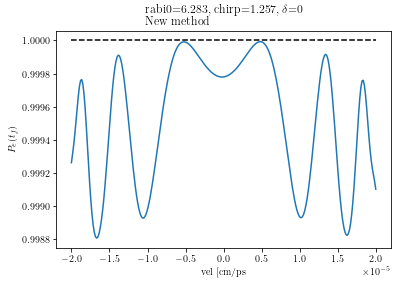

In [14]:
#print(result.states[-1])
excited = np.asarray([np.abs(result.states[-1][2*i+1,2*i+1]) for i in range(N_bins)])
#print(excited)
print(np.sum(excited))
plt.plot(velocity_bins,excited)
plt.xlabel("vel [cm/ps")
plt.ylabel(r"$P_e(t_f)$")
plt.title(r"rabi0={:.3f}, chirp={:.3f}, $\delta$={:.0f}".format(flip_pulse["rabi0"],flip_pulse["chirp"],flip_pulse["detuning"])+"\n New method")
plt.hlines(1,-2e-5,2e-5,ls="dashed",color="black")
#plt.savefig("./figures/cmt/new_method.jpg")
plt.show()